In [2]:
import os
import os.path as op
import json
import cv2
import base64
import numpy as np
from tqdm import tqdm
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

from maskrcnn_benchmark.structures.tsv_file_ops import tsv_reader, tsv_writer
from maskrcnn_benchmark.structures.tsv_file_ops import generate_linelist_file
from maskrcnn_benchmark.structures.tsv_file_ops import generate_hw_file
from maskrcnn_benchmark.structures.tsv_file import TSVFile
from maskrcnn_benchmark.data.datasets.utils.image_ops import img_from_base64

In [3]:
orig_root = '../../../../datasets/coco/coco_oscar_preexacted_vvl'
tsv_feature_filename = op.join(orig_root, 'train.feature.tsv')

oscar_props = dict()
# feat_imgkeys, nboxes_all
i = -1
for (img_key, props) in tqdm(tsv_reader(tsv_feature_filename)):
    oscar_props[img_key] = json.loads(props)
    i -=1
    if i == 0:
        break

# 113287 it, time: 05:33

113287it [02:49, 667.48it/s]


In [51]:
mini_root = '../../../../datasets/coco_my_mini_vvl'
tsv_feature_filename = op.join(mini_root, 'train.feature.tsv')

mini_props = dict()
# feat_imgkeys, nboxes_all
for (img_key, props) in tqdm(tsv_reader(tsv_feature_filename)):
    mini_props[img_key] = json.loads(props)

50it [00:00, 968.47it/s]


In [52]:
nboxes_all = np.array([p['num_boxes'] for p in oscar_props.values()])

/home/dlserver3/anaconda3/envs/pt181cu111/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


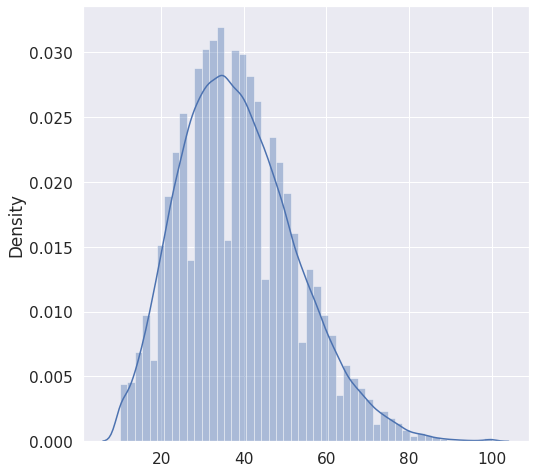

In [53]:
plt.figure(figsize=(8,8))
# plt.hist(nboxes_all, bins=500);
sns.distplot(nboxes_all);

In [54]:
print('Min boxes:', nboxes_all.min())
print('Max boxes:', nboxes_all.max())
print('Mean boxes:', nboxes_all.mean())

Min boxes: 10
Max boxes: 100
Mean boxes: 38.622489782587586


In [55]:
mini_props.keys()

dict_keys(['318556', '116100', '379340', '134754', '538480', '476220', '299675', '32275', '302443', '25470', '513461', '18691', '285579', '266366', '226658', '124567', '293605', '321194', '479495', '539984', '28231', '350235', '314265', '389006', '31813', '465049', '360334', '524679', '279672', '385716', '44816', '360306', '122802', '515040', '161657', '72704', '28149', '257263', '520049', '503598', '230843', '231029', '174028', '480489', '56972', '187042', '101891', '90359', '213532', '24091'])

In [56]:
# feat_imgkeys_ar = np.array(feat_imgkeys)
# feat_dict = {img_key: nboxes_all[i] for i, img_key in enumerate(feat_imgkeys)}

# ids = [318556, 116100, 379340, 134754, 538480]

num_boxes_ids = [imgkey for imgkey in mini_props.keys() if imgkey in oscar_props.keys()]
print(num_boxes_ids)

['318556', '116100', '379340', '134754', '538480', '476220', '299675', '32275', '302443', '25470', '513461', '18691', '285579', '266366', '226658', '124567', '293605', '321194', '479495', '539984', '28231', '350235', '314265', '389006', '31813', '465049', '360334', '524679', '279672', '385716', '44816', '360306', '122802', '515040', '161657', '72704', '28149', '257263', '520049', '503598', '230843', '231029', '174028', '480489', '56972', '187042', '101891', '90359', '213532', '24091']


In [57]:
# sel_feats = {}
# for line in tqdm(tsv_reader(tsv_feature_filename)):
#     if int(line[0]) in ids:
#         props = json.loads(line[1])
#         sel_feats[line[0]] = props['features']
#     #break

In [58]:
def decode_b64_feats(string, num_feats):
    return np.frombuffer(base64.b64decode(string), np.float32).reshape((num_feats, -1))

import io
oscar_feats_decoded = {}
mini_feats_decoded = {}
for i, key in enumerate(num_boxes_ids):
    oscar_feats_decoded[key] = decode_b64_feats(oscar_props[key]['features'], oscar_props[key]['num_boxes'])
    mini_feats_decoded[key] = decode_b64_feats(mini_props[key]['features'], mini_props[key]['num_boxes'])

In [59]:
sample_key = num_boxes_ids[0]
oscar_feats_decoded[sample_key][:10, -6:]

array([[0.497, 0.236, 0.581, 0.31 , 0.084, 0.074],
       [0.   , 0.   , 0.837, 0.629, 0.837, 0.629],
       [0.763, 0.788, 0.929, 0.883, 0.166, 0.095],
       [0.349, 0.761, 0.955, 0.999, 0.606, 0.238],
       [0.389, 0.667, 0.491, 0.728, 0.103, 0.061],
       [0.   , 0.087, 0.21 , 0.561, 0.21 , 0.474],
       [0.124, 0.67 , 0.226, 0.728, 0.102, 0.058],
       [0.555, 0.813, 0.815, 0.968, 0.26 , 0.156],
       [0.023, 0.635, 0.933, 0.836, 0.91 , 0.201],
       [0.429, 0.306, 0.637, 0.513, 0.208, 0.207]], dtype=float32)

In [60]:
mini_feats_decoded[sample_key][:10, -6:]

array([[0.498, 0.236, 0.58 , 0.309, 0.082, 0.073],
       [0.   , 0.   , 0.831, 0.627, 0.831, 0.627],
       [0.738, 0.774, 0.93 , 0.905, 0.192, 0.131],
       [0.346, 0.762, 0.951, 0.999, 0.605, 0.236],
       [0.389, 0.666, 0.492, 0.728, 0.103, 0.062],
       [0.124, 0.67 , 0.226, 0.728, 0.102, 0.058],
       [0.   , 0.09 , 0.211, 0.56 , 0.211, 0.47 ],
       [0.553, 0.811, 0.815, 0.97 , 0.262, 0.159],
       [0.244, 0.671, 0.374, 0.729, 0.13 , 0.058],
       [0.428, 0.304, 0.635, 0.514, 0.207, 0.21 ]], dtype=float32)

In [61]:
def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

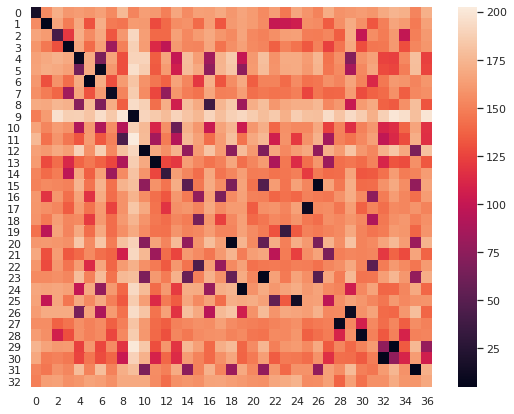

In [115]:
sample_key = num_boxes_ids[0]
boxes_mini = mini_feats_decoded[sample_key][:, -6:-2]
boxes_oscar = oscar_feats_decoded[sample_key][:, -6:-2]
feats_mini = mini_feats_decoded[sample_key][:, :-6]
feats_oscar = oscar_feats_decoded[sample_key][:, :-6]

squares = np.zeros((boxes_mini.shape[0], boxes_oscar.shape[0]))
dists = np.zeros_like(squares)
for i, box_m in enumerate(boxes_mini):
    for j, box_o in enumerate(boxes_oscar):
        #print(box_m, box_o)
        #input()
        squares[i, j] = bb_intersection_over_union(box_m, box_o)
        dists[i, j] = np.linalg.norm(feats_mini[i] - feats_oscar[j])

#print(squares)
sq_max = np.zeros_like(squares)
sq_max[np.arange(len(squares)), squares.argmax(1)] = 1

# print(sq_max)

plt.figure(figsize=(9,7))
# sns.heatmap(sq_max);
sns.heatmap(dists);

In [114]:
feat_mini = mini_feats_decoded[sample_key][0, :-6]
feat_mini2 = mini_feats_decoded[sample_key][1, :-6]

feat_oscar = oscar_feats_decoded[sample_key][0, :-6]

dists=
dist = np.linalg.norm(feat_mini - feat_mini2)
dist

SyntaxError: invalid syntax (<ipython-input-114-8e1bd104e19f>, line 6)

In [29]:
filename = '../../../../datasets/coco_2014/images/train2014/COCO_train2014_000000' + '318556' + '.jpg'


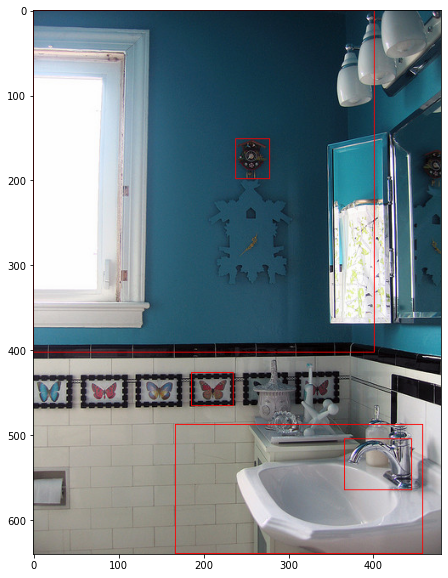

In [71]:
plt.figure(figsize=(16,10))

im = Image.open(filename)
draw = ImageDraw.Draw(im)

#for (bbox, text, conf) in ocr_all[idx]:
#    draw_box(draw, bbox, k)

for bbox in sel_feats_dec['318556'][0:5, -6:]:
    x1 = bbox[0] * im.width
    y1 = bbox[1] * im.height
    x2 = bbox[2] * im.width
    y2 = bbox[3] * im.height
    
    draw.rectangle((x1, y1, x2, y2), outline=255)

plt.imshow(im);

In [8]:
# a[0] = img_key
# a[1] = json string
# = json.loads(a[1])
#j['num_boxes']

In [9]:
tsv_label_filename = op.join(orig_root, 'train.label.tsv')
label_imgkeys = []
label_props = []
for line in tqdm(tsv_reader(tsv_label_filename)):
    label_imgkeys.append(line[0])
    props = json.loads(line[1])
    label_props.append(props)
    #break
# props

113287it [00:06, 17246.18it/s]


In [10]:
for key_f, key_l in tqdm(zip(feat_imgkeys, label_imgkeys)):
    if key_f != key_l:
        print('WOW, SHIT!')


113287it [00:00, 2967543.62it/s]


In [11]:
for img_props in label_props:
    conf = 1.0
    for box in img_props:
        if box['conf'] > conf and box['conf'] < 1:
            print('HOLY SHIT!')
            # print(box)
        else:
            conf = box['conf']

# Class 'Animal' + 'Shellfish' - confs > 1 !!! (1.84, 1.93, 1.14, 1.99)
# В остальном конфиденс скоры строго убывают

In [12]:
print(feat_imgkeys[0], nboxes_all[0])

522418 28


In [13]:
props_len_all = [len(props) for props in label_props]
props_len_all = np.array(props_len_all)

/hdd/anaconda3/envs/pt171cu101/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


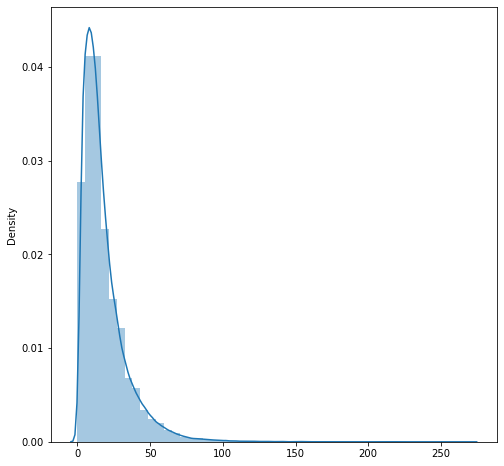

In [16]:
plt.figure(figsize=(8,8))
#plt.hist(props_len_all, bins=500);
sns.distplot(props_len_all);

In [17]:
print('Min objects:', props_len_all.min())
print('Max objects:', props_len_all.max())
print('Mean objects:', props_len_all.mean())

Min objects: 0
Max objects: 270
Mean objects: 18.044859516096288
